# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## 1. Подготовка

In [1]:
import numpy as np
import pandas as pd

import re
from pymystem3 import Mystem
import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb


from sklearn.metrics import f1_score


import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#откроем файл
try:
    data_text=pd.read_csv('desktop/datasets/toxic_comments.csv')
except:
    data_text=pd.read_csv('/datasets/toxic_comments.csv')

data_text.head() 

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
#просмотрим основную информацию о датасете
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
data_text.duplicated().sum()

0

0    0.898321
1    0.101679
Name: toxic, dtype: float64


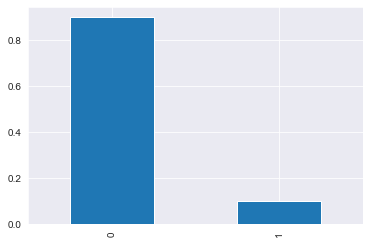

In [5]:
#как часто модель предсказывала класс «1» или «0» по Дереву решений:
class_frequency_dtc = pd.Series(data_text['toxic']).value_counts(normalize=True)
print(class_frequency_dtc)

#на диаграмме
sns.set_style('darkgrid')
class_frequency_dtc.plot(kind='bar');

In [6]:
#обработаем регистр
data_text['text']=data_text['text'].str.lower()

In [7]:
%%time
#сделаем леммитизацию
m = Mystem()

def lemmatize_text(text):
    lemm_text = "".join(m.lemmatize(text))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

data_text['lemm_text'] = data_text['text'].apply(lemmatize_text)

CPU times: user 31.7 s, sys: 3.87 s, total: 35.5 s
Wall time: 2min 13s


In [8]:
#посмотрим что получилось
data_text.head()

,text,toxic,lemm_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...


In [9]:
#разделим на признаки и целевую переменную
features = data_text['lemm_text']
target = data_text['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)


In [10]:
#стоп-слова и векторизация текста
nltk.download('stopwords')

stopwords = set(nltk_stopwords.words('english'))

tf_idf = TfidfVectorizer(stop_words=stopwords) 
features_train = tf_idf.fit_transform(features_train)
features_test = tf_idf.transform(features_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<b>ВЫВОД:</b>
В процессе изучения данных было выполнено:

- тексты были очищены и лемматизированы;
- проверен баланс классов и в результате установлено, что  имеет место значительный дисбаланс, таким образом это необходимо учесть в дальнейшем при обучении моделей. 
- выделены признаки и целевая переменная;
- для векторизации текстов был использован TfidfVectorizer()

## 2. Обучение

Будем использовать Логистическую регрессию, LightGBM и модель Random Forest

In [11]:
%%time

#Логистическая регрессия с пареметром class_weight = 'balanced'
regressor = LogisticRegression(fit_intercept=True, 
                                class_weight='balanced', 
                                random_state=12345,
                                solver='liblinear'
                                 )

lg_param = {'C': [0.1, 1, 10]}

#обучаем 
lg_model = GridSearchCV(regressor, param_grid=lg_param, scoring='f1', cv=3)
lg_model.fit(features_train, target_train)

CPU times: user 36.6 s, sys: 503 ms, total: 37.1 s
Wall time: 9.45 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=12345,
                                          solver='liblinear'),
             param_grid={'C': [0.1, 1, 10]}, scoring='f1')

In [12]:
print(lg_model.best_score_)
print(lg_model.best_params_)

0.7647395724887668
{'C': 10}


### LightGBM

In [13]:
%%time

regressor_lgbm = LGBMClassifier(class_weight='balanced',random_state = 12345)

lgbm_param= {'max_depth' : [-1],
                'learning_rate' : [0.2],
                'n_estimators' : [100,200,1000]
               }

lgbm_model = GridSearchCV(estimator=regressor_lgbm, 
                          param_grid=lgbm_param, 
                          scoring = 'f1', 
                          cv=3)

lgbm_model.fit(features_train, target_train)


CPU times: user 45min 3s, sys: 44.1 s, total: 45min 47s
Wall time: 6min 32s


GridSearchCV(cv=3,
             estimator=LGBMClassifier(class_weight='balanced',
                                      random_state=12345),
             param_grid={'learning_rate': [0.2], 'max_depth': [-1],
                         'n_estimators': [100, 200, 1000]},
             scoring='f1')

In [14]:
print(lgbm_model.best_score_)
print(lgbm_model.best_params_)

0.7607782928393162
{'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 1000}


### Random Forest 

In [15]:
%%time

forest_regressor = RandomForestClassifier(class_weight='balanced',random_state = 12345, n_jobs=-1 )

forest_param = {'n_estimators': range(20, 40, 5),
                     'max_depth': range(4, 8, 2),
                     }

forest_model = GridSearchCV(estimator=forest_regressor, 
                            param_grid=forest_param, 
                            scoring='f1', 
                            cv=3)

forest_model.fit(features_train, target_train)


CPU times: user 17 s, sys: 2.35 s, total: 19.3 s
Wall time: 30.4 s


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=12345),
             param_grid={'max_depth': range(4, 8, 2),
                         'n_estimators': range(20, 40, 5)},
             scoring='f1')

In [16]:
print(forest_model.best_score_)
print(forest_model.best_params_)

0.3025906364532773
{'max_depth': 6, 'n_estimators': 35}


## 3.  ВЫВОДЫ

In [17]:
#лучшие модели
best_forest=forest_model.best_estimator_
best_lgbm=lgbm_model.best_estimator_
best_linear=lg_model.best_estimator_

In [18]:
#предсказываем по лучшим моделям
forest_predict = best_forest.predict(features_test)
lgbm_predict = best_lgbm.predict(features_test)
linear_predict = best_linear.predict(features_test)

#финальный f1 на тесте
print('Random Forest',f1_score(target_test, forest_predict))
print('LightGBM',f1_score(target_test, lgbm_predict))
print('Logistic Regression',f1_score(target_test, linear_predict))

Random Forest 0.3329835940480732
LightGBM 0.7739387956564658
Logistic Regression 0.771059312254789


In [19]:
#сводная таблица с результатами 
columns = ['Модель', 'f1-мера на тесте','f1-мера на трейне']

linear_regression_model = ['Логистическая регрессия', f1_score(target_test, linear_predict),lg_model.best_score_]
lightGBM_model = ['LightGBM', f1_score(target_test, lgbm_predict),lgbm_model.best_score_]
random_forest_model = ['Случайный лес', f1_score(target_test, forest_predict),forest_model.best_score_]

table = pd.DataFrame([linear_regression_model, lightGBM_model, random_forest_model], columns = columns)

table

,Модель,f1-мера на тесте,f1-мера на трейне
0,Логистическая регрессия,0.771059,0.764740
1,LightGBM,0.773939,0.760778
2,Случайный лес,0.332984,0.302591


<b>ВЫВОД:</b>
1. Изучены и подготовлены данные, в том числе:
    
    - тексты были очищены и лемматизированы;
    - проверен баланс классов и в результате установлено, что имеет место значительный дисбаланс, таким образом это учтено при дальнейшем при обучении моделей внесением class_weight='balanced'.
    - выделены признаки и целевая переменная;
    - для векторизации текстов  использован TfidfVectorizer()
    
2. Обучены три модели:  Logistic Regression, LGBMClassifier и Random Forest Classifier. Получены лучшие параметры на тесте и трейне, данные сведены в общую таблицу.
3. Установлено, что лучшая модель - LGBMClassifier, худшая - Random Forest, однако LGBMClassifier обучалась значительно дольше.
